# Fully connected ANN for predicting streamflow error in PCR model

A fully connected Artificial Neural Network is built using tensorflow optimizing the number of layers and neurons in each layer.

In [ ]:
!pip install -q -U keras-tuner
!pip install hydroeval

Trial 56 Complete [00h 00m 03s]
val_mean_squared_error: 614500.625

Best val_mean_squared_error So Far: 511812.53125
Total elapsed time: 00h 02m 31s
INFO:tensorflow:Oracle triggered exit
Units: 200, 175
Epoch 1/150
145/145 [==============================] - 1s 6ms/step - loss: 703424.6250 - mean_squared_error: 703144.7500 - val_loss: 782541.3125 - val_mean_squared_error: 774050.1875
Epoch 2/150
145/145 [==============================] - 1s 5ms/step - loss: 412319.0000 - mean_squared_error: 412517.3125 - val_loss: 553596.8750 - val_mean_squared_error: 543225.3750
Epoch 3/150
145/145 [==============================] - 1s 5ms/step - loss: 277242.6250 - mean_squared_error: 277142.0000 - val_loss: 442530.3438 - val_mean_squared_error: 434142.2812
Epoch 4/150
145/145 [==============================] - 1s 5ms/step - loss: 215384.9844 - mean_squared_error: 215403.1250 - val_loss: 384236.3438 - val_mean_squared_error: 377087.2500
Epoch 5/150
145/145 [==============================] - 1s 5ms/ste

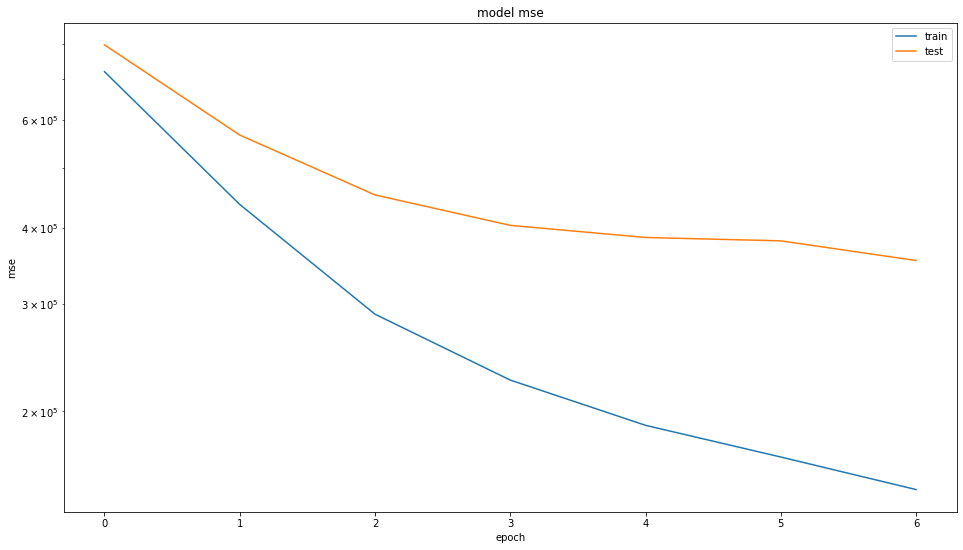

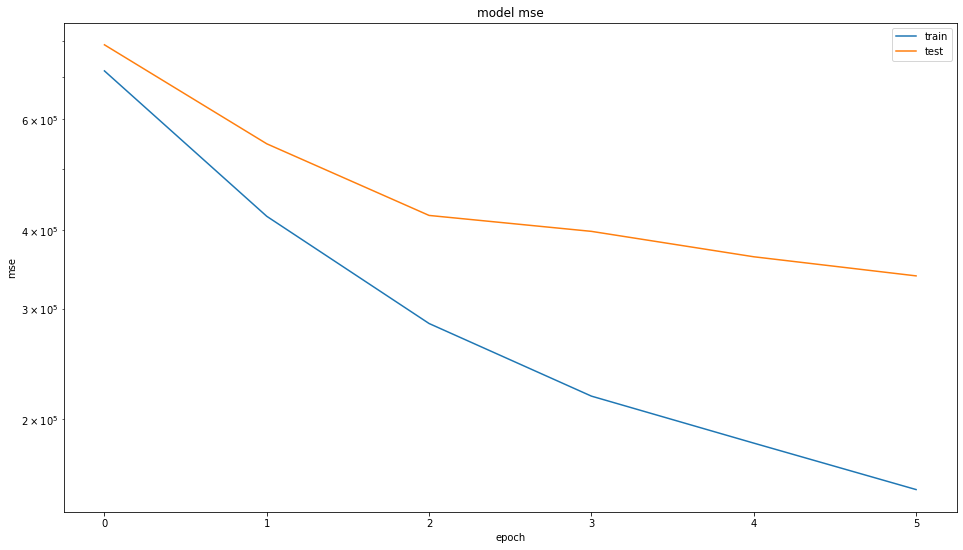

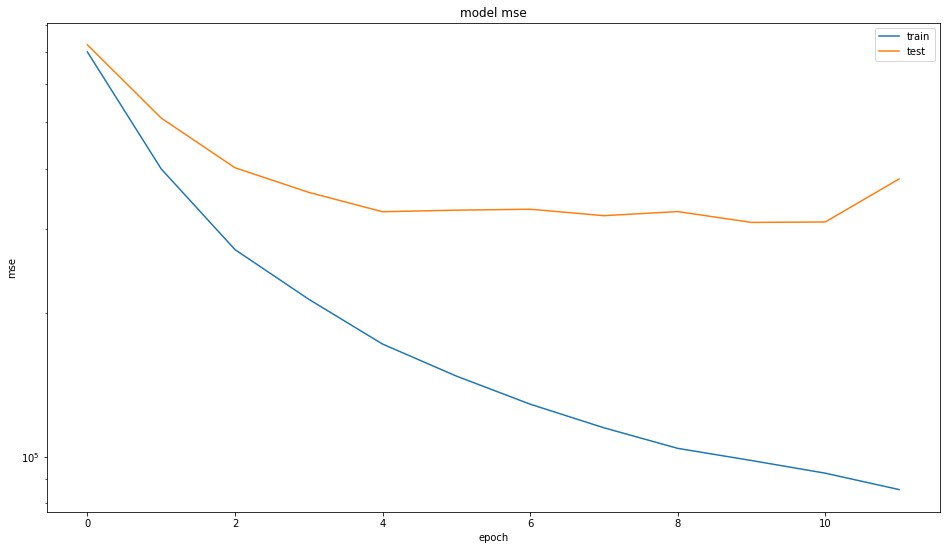

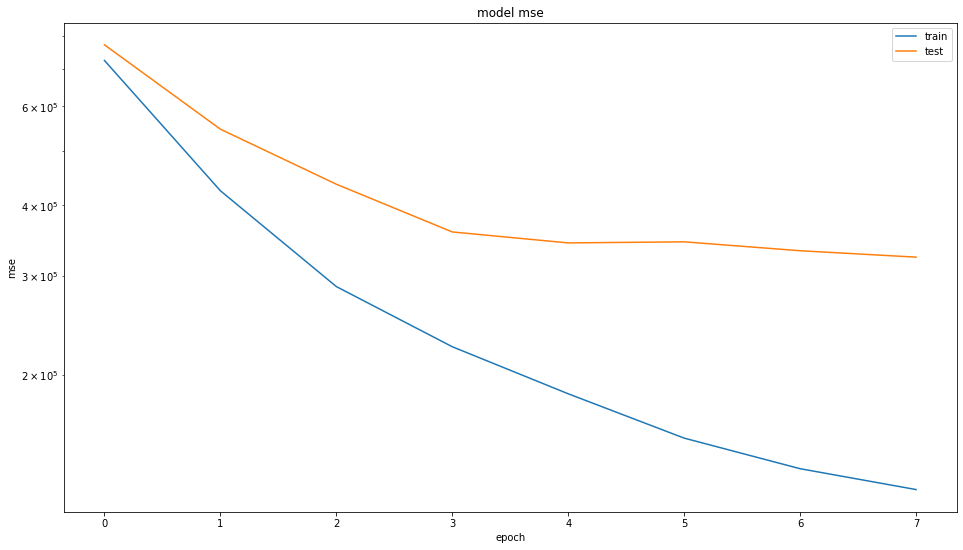

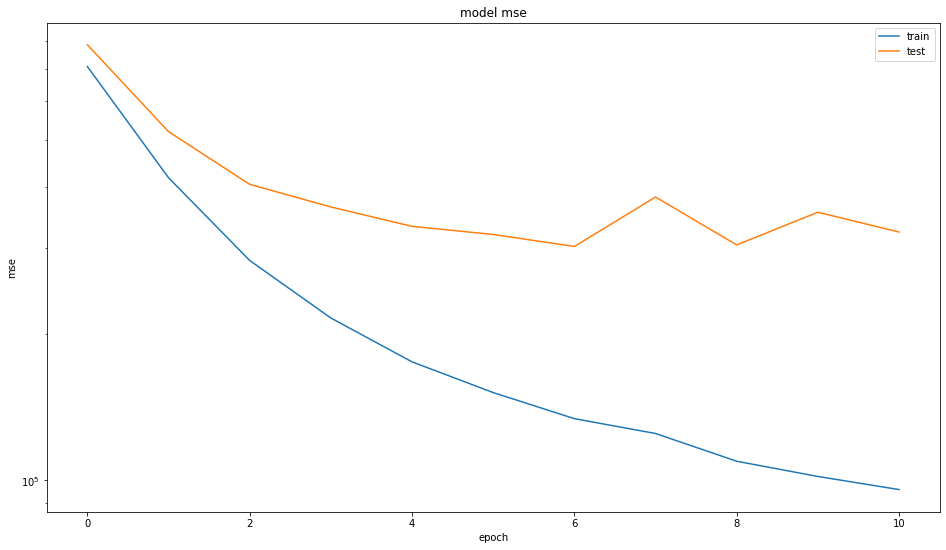

In [ ]:
RUNS = 5              #number of runs to perform
DIFF_TEST = False     #whether to use different test sets for each run
LAG = True            #whether to use lagged variables or not
LOCATION = 'lobith'   #location of the data to be plotted

#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import keras_tuner as kt
import hydroeval as he

#set in and out folder paths (change path to your own)
in_folder = f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/formatted_data/{LOCATION}/'
out_folder = f'/content/drive/MyDrive/ADS/Final Thesis Project/temp/predictions/{LOCATION}/'

#define the model
def baseline_model(hp):
  model = keras.Sequential()

  for i in range(2):
    model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 25, 200, step=25),activation='relu'))
    model.add(tf.keras.layers.Dropout(0.05))
    
  model.add(keras.layers.Dense(1, activation='linear'))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.losses.MeanSquaredError()])
  return model

#initiate the summary string by writing the current time and date
starting_time = datetime.now()
fcn_summary = starting_time.strftime("%d/%m/%Y %H:%M:%S") + '\n'

#loop for all runs/test sets
for i in range(1,RUNS+1):
  print('RUN NUMBER:',i)

  #read the data according to the mode
  if DIFF_TEST:
    path = in_folder + 'no_'*(not LAG) + f'lag_{i}.npz'
  else:
    path = in_folder + 'no_'*(not LAG) + f'lag_{5}.npz'

  with np.load(path) as f:
    X_train, X_test, y_train, y_test, obs = list(f.values())

  #instantiate the Hyperband tuner
  tuner = kt.Hyperband(baseline_model,
                          overwrite= True,
                          objective='val_mean_squared_error',
                          max_epochs = 150,
                          directory='my_dir',
                          project_name='no_'*(not LAG) + 'lag_' + 
                          'run_'*(not DIFF_TEST) + 'test_'*DIFF_TEST + str(i))
  
  #create a callback to stop training early after reaching a certain value for the validation loss.
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=10)

  #run the tuner
  tuner.search(X_train, y_train, epochs=150, validation_split=0.2, callbacks=[stop_early])

  #get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  params = f"Units: {best_hps.get('units_0')}, {best_hps.get('units_1')}"# Learning rate: {best_hps.get('learning_rate')}"
  print(params)

  # build the model with the optimal hyperparameters and find the optimal number of epochs
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(X_train, y_train, epochs=150, validation_split=0.2)
  mse_per_epoch = history.history['val_mean_squared_error']
  best_epoch = mse_per_epoch.index(min(mse_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

  #re-instantiate the hypermodel and train it with the optimal number of epochs from above.
  hypermodel = tuner.hypermodel.build(best_hps)
  history = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

  #save a plot of the training history
  plt.figure(figsize = (16,9))
  plt.plot(history.history['mean_squared_error'], label = 'train')
  plt.plot(history.history['val_mean_squared_error'], label = 'test')
  plt.title('model mse')
  plt.ylabel('mse')
  plt.xlabel('epoch')
  plt.yscale('log')
  plt.legend()
  plt.savefig(out_folder + 'no_'*(not LAG) + 'lag/fcn/history_' + 
              'run_'*(not DIFF_TEST) + 'test_'*DIFF_TEST + f'{i}.png')

  #compute the FCN  predictions and evaluate them
  y_pred =  hypermodel.predict(X_test)
  pred = obs - y_test + y_pred.flatten()

  nse = he.evaluator(he.nse, pred, obs)
  kge, r, alpha, beta = he.evaluator(he.kge, pred, obs)


  #write the results in the log string
  fcn_summary += (f'***\nModel: FCN\nLag: {LAG}\nParameters: {params}\n' +
                  'Test split: ' + str(i)*DIFF_TEST + '5'*(not DIFF_TEST) +
                  f'\nNSE: {nse[0]}\nKGE: {kge[0]}\n')

  #save the predictions in the drive
  np.save(out_folder + 'no_'*(not LAG) + 'lag/fcn/fcn_' +
          'run_'*(not DIFF_TEST) + 'test_'*DIFF_TEST + str(i), pred)

#print the time when the algorithm finished
ending_time = datetime.now()
duration = ending_time - starting_time
fcn_summary += '***\nEnd time: ' + ending_time.strftime("%H:%M:%S") + '\n'
fcn_summary += f'Duration: {duration}'
print(fcn_summary)

#save the results
with open(out_folder + 'no_'*(not LAG) + 'lag/fcn/fcn_' + 
          'run'*(not DIFF_TEST) + 'test'*DIFF_TEST +'_summary.txt', 'w') as f:
    f.write(fcn_summary)